In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/itsguptaaman/Datasets/main/dataset_full.csv",index_col=None)
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [3]:
df.drop_duplicates(inplace=True)

In [4]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score

In [5]:
wcss=[]
for i in range(1,20):
    kmean=KMeans(n_clusters=i, init="k-means++",random_state=100)
    kmean.fit(df)
    wcss.append(kmean.inertia_)

Text(0, 0.5, 'WCSS or Inetria')

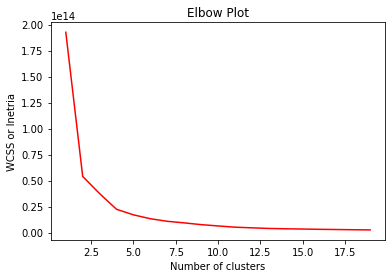

In [6]:
plt.figure()
plt.plot(range(1,20), wcss, color="r")
# plt.axvline(x=10)
# plt.axhline(y=0.6)
plt.title("Elbow Plot")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS or Inetria")

In [7]:
k_mean=KMeans(n_clusters=2, init="k-means++",random_state=100)

In [8]:
k_mean.fit(df)

KMeans(n_clusters=2, random_state=100)

In [9]:
labels=k_mean.labels_

In [10]:
silhouette_score(df, labels)

0.890420927447292

In [11]:
# x_train.drop(columns=["cluster_no"],inplace=True)

In [12]:
df["cluster_no"]=k_mean.predict(df)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [14]:
x=df.drop(columns="phishing")
y1=df[["cluster_no","phishing"]]
y=df["phishing"]

In [15]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.25,random_state=100)

In [16]:

# determine the mutual information
mutual_info = mutual_info_classif(x_train, y_train)
mutual_info
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info=mutual_info.sort_values(ascending=False)[:37]

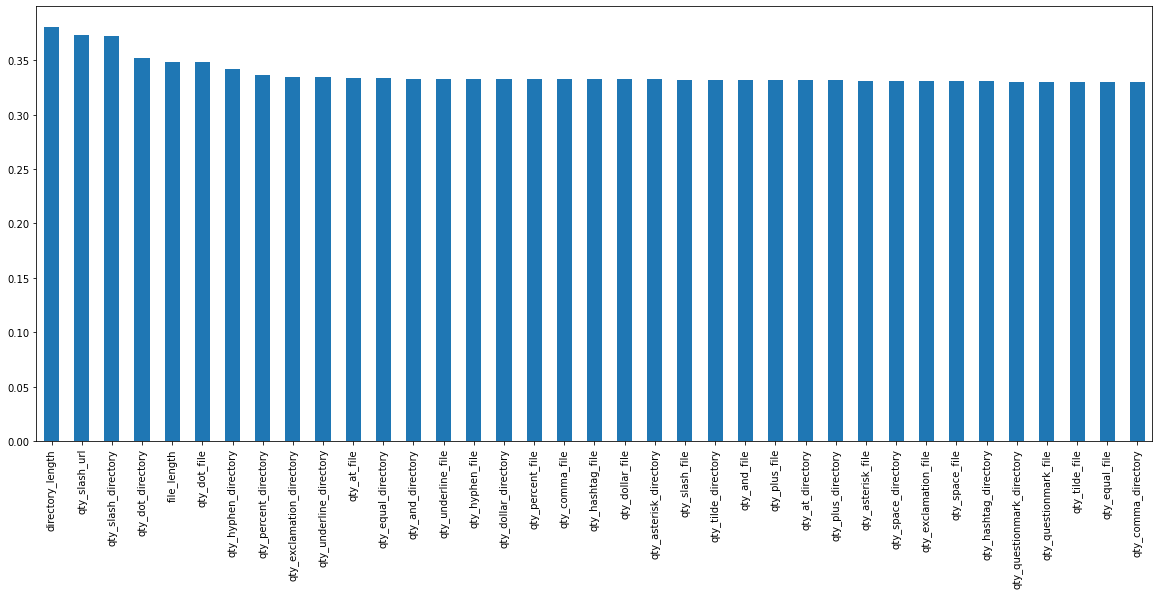

In [17]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [18]:
new_x=mutual_info.index
x_train=x_train[new_x]

In [19]:
def correlation(x_train,threshold):
    colum_corr=set() #set of all names of correlated columns
    corr_matrix=x_train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we want absolute coefficient values
                colum_name=corr_matrix.columns[i] #getting the names of column
                colum_corr.add(colum_name)
    return list(colum_corr)

In [20]:

names=correlation(x_train,0.84)
x_train=x_train.drop(columns=names)
column=x_train.columns
column=list(column)
column

['directory_length',
 'qty_slash_url',
 'qty_dot_directory',
 'file_length',
 'qty_hyphen_directory',
 'qty_percent_directory',
 'qty_underline_directory',
 'qty_hyphen_file']

In [21]:
column.insert(-1,"cluster_no")

In [22]:
column

['directory_length',
 'qty_slash_url',
 'qty_dot_directory',
 'file_length',
 'qty_hyphen_directory',
 'qty_percent_directory',
 'qty_underline_directory',
 'cluster_no',
 'qty_hyphen_file']

In [23]:
x=df[column]
y=df[["cluster_no","phishing"]]

In [24]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.25,random_state=100)

In [25]:
X_train=x_train[x_train["cluster_no"]==0].copy()
X_train.drop(columns="cluster_no",inplace=True)
Y_train=y_train[y_train["cluster_no"]==0].copy()
Y_train.drop(columns="cluster_no",inplace=True)
X_test=x_test[x_test["cluster_no"]==0].copy()
X_test.drop(columns="cluster_no",inplace=True)
Y_test=y_test[y_test["cluster_no"]==0].copy()
Y_test.drop(columns="cluster_no",inplace=True)

In [26]:
log_reg=LogisticRegression(solver="saga")

In [27]:
log_reg.fit(X_train,Y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(solver='saga')

In [28]:
log_reg.score(X_test,Y_test)

0.8856440790095454

In [29]:
y_pred=log_reg.predict(X_test)

In [30]:
def model_evaluation(y_test,y_predict):
    from sklearn.metrics import confusion_matrix
    # t : True, f : False, n : Negative, p : Positive
    # .ravel will give ndarray in 1d array 
    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    recall = (tp)/(tp+fn)
    precision = (tp)/(tp+fp)
    f1 = ( 2 * ( precision * recall ) / ( precision + recall ) )
    specificity = (tn)/(tn+fp)
    results = {"Accuracy":accuracy,"Recall" : recall, "Precision" : precision,"F1" : f1,
              "Specificity" : specificity}
    return results

In [31]:
model_evaluation(Y_test,y_pred)

{'Accuracy': 0.8856440790095454,
 'Recall': 0.8274153592072667,
 'Precision': 0.8375592086932293,
 'F1': 0.8324563832733316,
 'Specificity': 0.916090961427749}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [ ]:

param={
    "C":[1,2,3],
    "kernel":[ 'poly', 'rbf',],
    "gamma":[0.001,0.01,0.1,],
    "coef0":[0.0,0.1,0.2],
    "shrinking":[False,True],
    "tol":[0.0001,0.001,],
    "cache_size":[200,500],
    "random_state":[33,100]
}

In [ ]:
svc=SVC()

In [ ]:
grid_svc=RandomizedSearchCV(svc,param_distributions=param)
grid_svc.fit(X_test,Y_test.vaues.ravel())

AttributeError: ignored

In [ ]:
grid_svc.best_estimator_